## Introduction to CML data processing - From raw signals to rain rates

<img src="https://wires.onlinelibrary.wiley.com/cms/asset/e241f352-21c4-49e7-a8f7-ecf6ff15686f/wat21337-fig-0001-m.jpg" alt="drawing" width="1300"/>

<img src="https://hess.copernicus.org/articles/24/2931/2020/hess-24-2931-2020-f03-web.png" alt="drawing" width="1000"/>

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('poligrain/src')
sys.path.append('pycomlink')

import poligrain as plg
import pycomlink as pycml

## Load OpenMRG example dataset

We have already learned about this in the previous notebook.

In [2]:
(
    ds_rad,
    ds_cmls,
    ds_gauges_municp,
    ds_gauge_smhi,
) = plg.example_data.load_openmrg(data_dir="example_data", subset="8d")

File already exists at example_data/openmrg_cml_8d.nc
Not downloading!
File already exists at example_data/openmrg_rad_8d.nc
Not downloading!
File already exists at example_data/openmrg_municp_gauge_8d.nc
Not downloading!
File already exists at example_data/openmrg_smhi_gauge_8d.nc
Not downloading!


In [6]:
ds_cmls

<xarray.Dataset> Size: 1GB
Dimensions:       (sublink_id: 2, cml_id: 364, time: 69120)
Coordinates:
  * sublink_id    (sublink_id) <U9 72B 'sublink_1' 'sublink_2'
  * cml_id        (cml_id) int64 3kB 10001 10002 10003 ... 10362 10363 10364
  * time          (time) datetime64[ns] 553kB 2015-07-22 ... 2015-07-29T23:59:50
    site_0_lat    (cml_id) float64 3kB ...
    site_0_lon    (cml_id) float64 3kB ...
    site_1_lat    (cml_id) float64 3kB ...
    site_1_lon    (cml_id) float64 3kB ...
    frequency     (sublink_id, cml_id) float64 6kB ...
    polarization  (sublink_id, cml_id) <U1 3kB ...
    length        (cml_id) float64 3kB ...
Data variables:
    tsl           (time, sublink_id, cml_id) float64 403MB ...
    rsl           (time, sublink_id, cml_id) float64 403MB ...
    R             (sublink_id, cml_id, time) float64 403MB ...
Attributes: (12/14)
    title:                 OpenMRG-CML
    version:               1.1
    source:                Swedish Meteorological and Hydrological Institute ...
    contact:               hydro.fou@smhi.se, jafet.andersson@smhi.se
    license:               https://creativecommons.org/licenses/by-sa/4.0
    doi:                   https://doi.org/10.5281/zenodo.6673750
    ...                    ...
    institution:           NA
    date:                  NA
    history:               NA
    naming convention:     NA
    license restrictions:  NA
    reference:             NA

Note, that this is data for 364 CMLs, each with two sublinks, with a temporal reslotion of 10 sec. For a 8-day period, this is approx. 1.2 GB of data if loaded into memory. CML data can be quite large!

In [9]:
print(f'{ds_cmls.nbytes/1e6:.2f} MB')

1208.24 MB


## Explore CML data

### The transmitted and received signal levels

ADD SOME TEXT HERE

- RSL most important for rainfall estimation
- TSL can be constant or vary with time if ATPC (automatic transmit power control) is enabled
- RSL and TSL are quantized, often at 0.3 dB for RSL and 1.0 dB for TSL

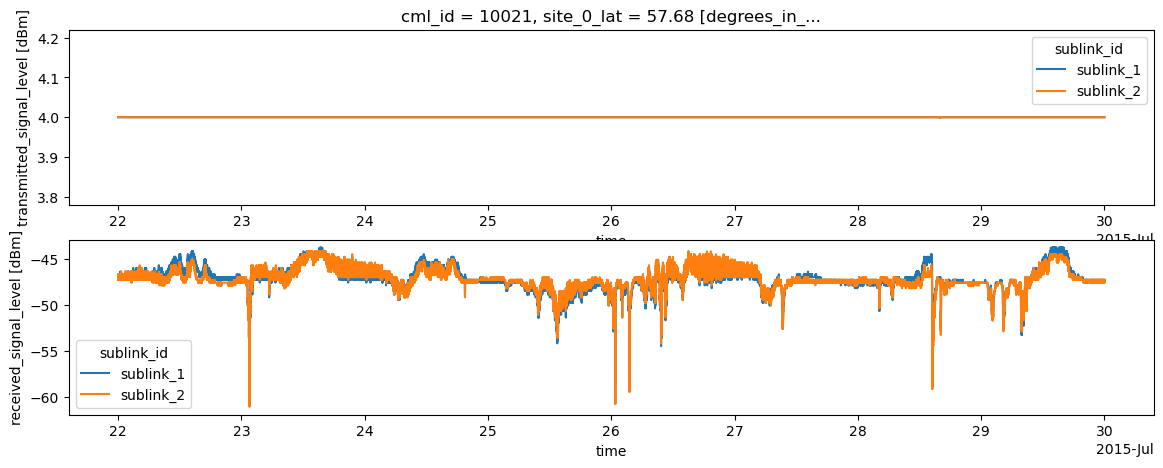

In [25]:
ds_cml = ds_cmls.isel(cml_id=20) 

fig, axs = plt.subplots(2, 1, figsize=(14, 5))
ds_cml.tsl.plot.line(x='time', ax=axs[0])
ds_cml.rsl.plot.line(x='time', ax=axs[1])
axs[1].set_title('');

 * rsl value of -99 is an outlier (some error happend at this time-step)
 
&#8594; replace such default values by NaN (Not a Number)

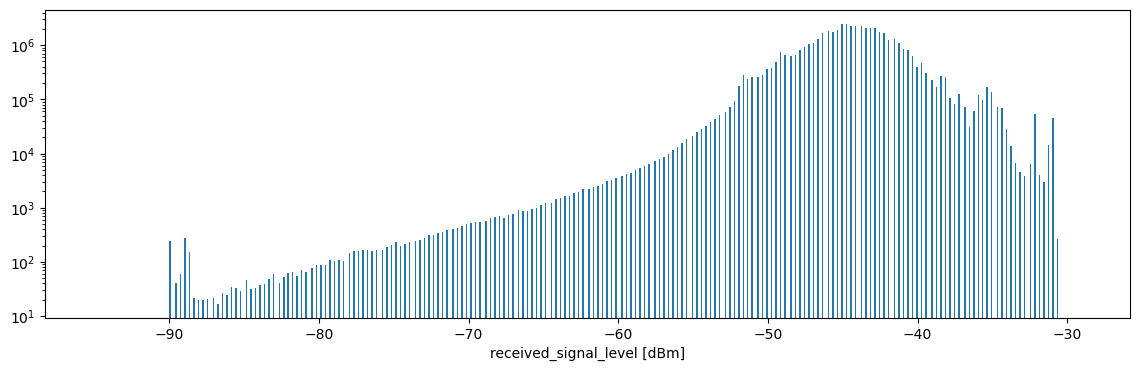

In [35]:
ds_cmls.rsl.plot.hist(bins=np.arange(-95, -29, 0.1), figsize=(14, 4))
plt.yscale('log')

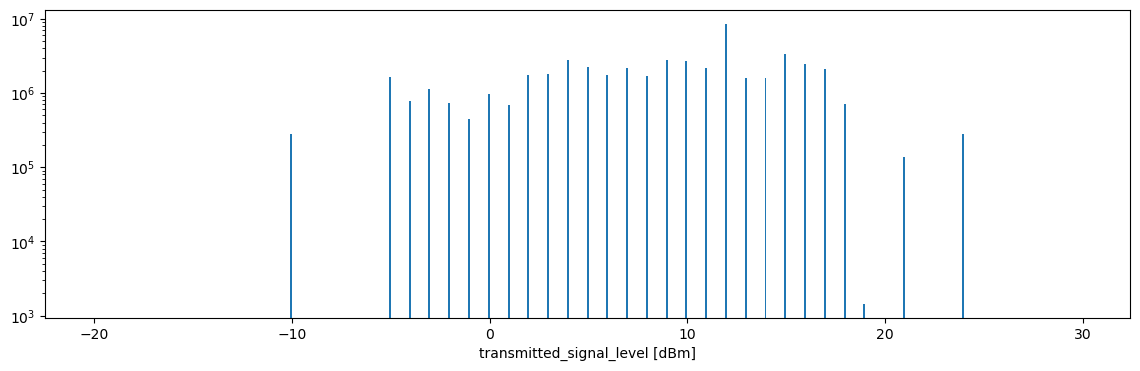

In [45]:
ds_cmls.tsl.plot.hist(bins=np.arange(-20, 30, 0.1), figsize=(14, 4))
plt.yscale('log')

### Exercise 1: Find CML with enabled ATPC

- 1.1: How many CMLs have the ATPC enabled? Plo a histogram of the range of the TSL values of each CML.


- 1.2: Find a CML with enabled ATPC and plot TSL and RSL. Can you explain what is happening during rain events?

- 1.3: Find the CML with the largest range of TSL values and plot TSL and RSL. (Hint: use `.argmax` to get the index of the maximum in a `xarray.DataArray`)

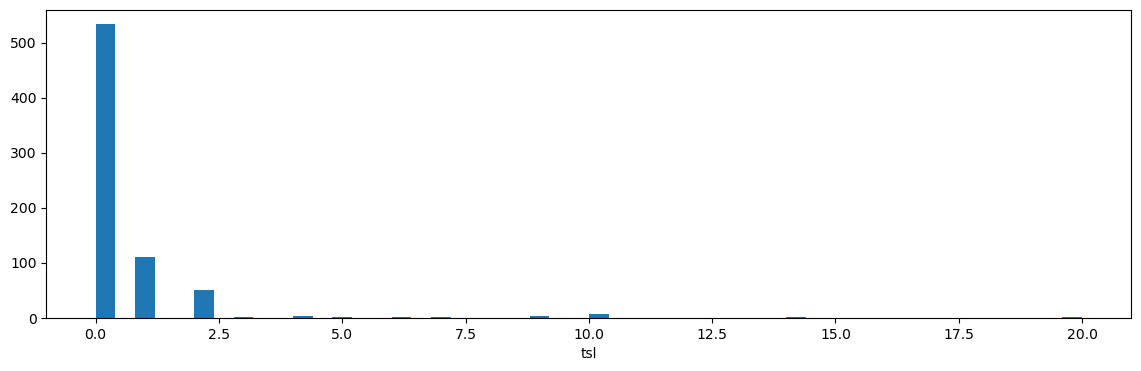

In [64]:
tsl_range = ds_cmls.tsl.max(dim='time') - ds_cmls.tsl.min(dim='time')
tsl_range.plot.hist(bins=50, figsize=(14, 4));

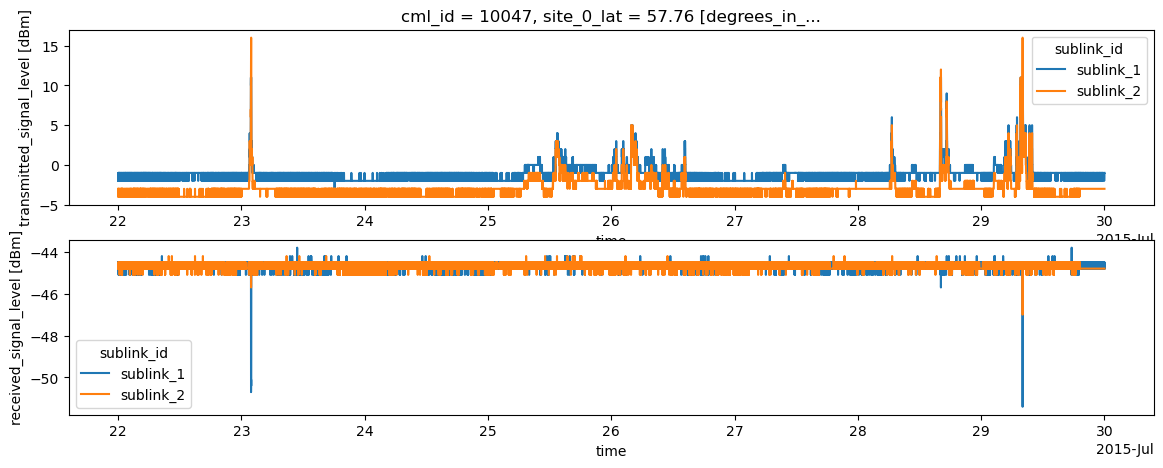

In [63]:
i_max = tsl_range.argmax(dim='cml_id').data[0]
ds_cml = ds_cmls.isel(cml_id=i_max)
fig, axs = plt.subplots(2, 1, figsize=(14, 5))
ds_cml.tsl.plot.line(x='time', ax=axs[0])
ds_cml.rsl.plot.line(x='time', ax=axs[1])
axs[1].set_title('');

## The total path loss (TL) calculated from TSL and RSL

TL = TSL - RSL

TL is the data that we typically work with. It increases during rain events because the rain causes additional attenuation along the path which add to the total path loss during clear sky conditions.

In [ ]:
ds_cmls['tl'] = ds_cmls.tsl - ds_cmls.rsla

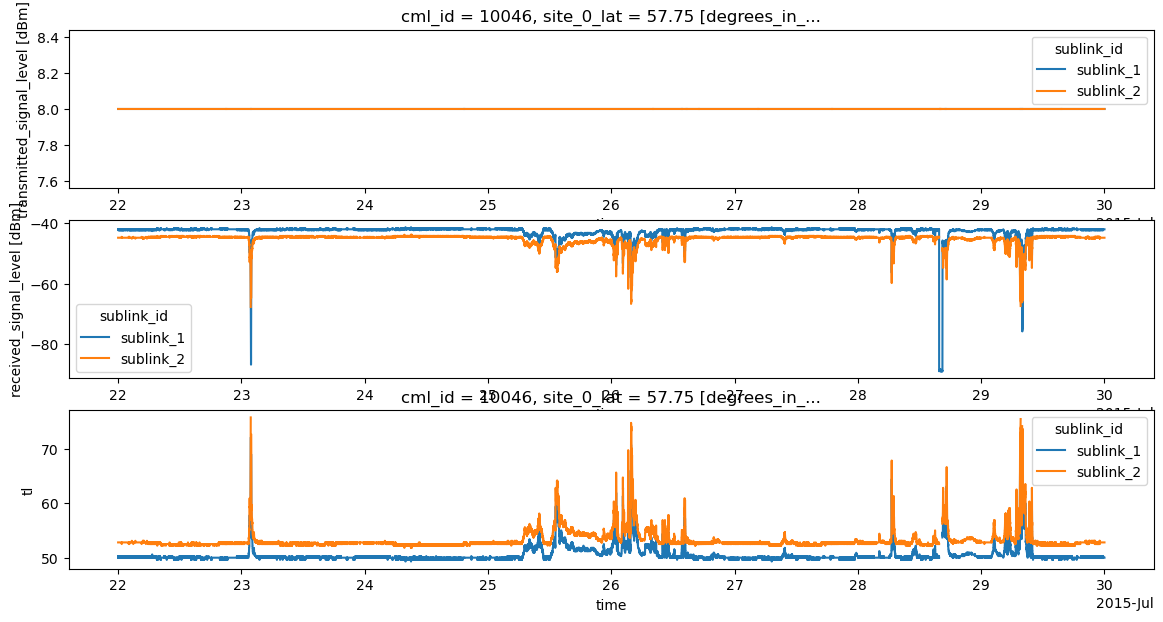

In [72]:
ds_cml = ds_cmls.isel(cml_id=45)
fig, axs = plt.subplots(3, 1, figsize=(14, 7))
ds_cml.tsl.plot.line(x='time', ax=axs[0])
ds_cml.rsl.plot.line(x='time', ax=axs[1])
ds_cml.tl.plot.line(x='time', ax=axs[2])
axs[1].set_title('');

### 3. Wet/dry detection

**Goal**: Find the rainy periods in the time-series

Rainfall generates high tl values for short periods
    
&#8594; How can we detect such periods? 

&#8594; We will first use a rolling standard deviation (RSD) as suggested by [Schleiß et al. 2010](https://ieeexplore.ieee.org/document/5438724) and then move to other methods.



<img src="https://hess.copernicus.org/articles/24/2931/2020/hess-24-2931-2020-f03-web.png" alt="drawing" width="1000"/>

### 3.1: Compute a rolling window standard deviation to perform a basic wet-dry classification

In [68]:
ds_cml['rsd'] = ds_cml.tl.rolling(time=60*6, center=True).std() # 60  min rolling window
threshold = 0.4
ds_cml['wet'] = ds_cml.rsd > threshold

 * use `xarray.DataArray.rolling()` to create a rolling window of length 360 timesteps (60 minutes)
 
 * `.rolling(center=True).std()` writes the windows standard deviation to the central time step

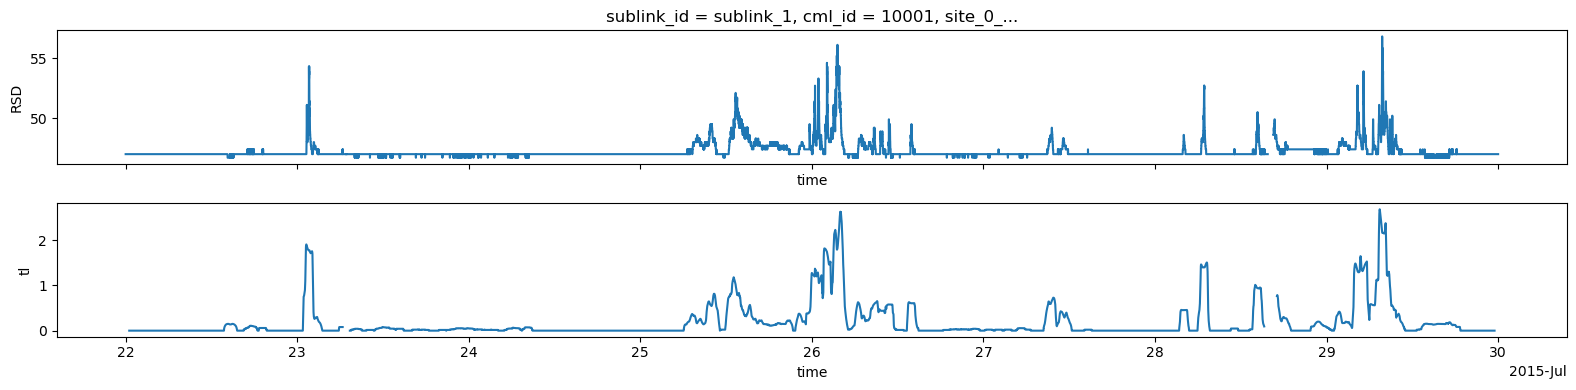

In [69]:
fig, axs = plt.subplots(2, 1, figsize=(16,4), sharex=True)
ds_cml.tl.plot.line(x='time', ax=axs[0])
ds_cml.rsd.plot.line(x='time', ax=axs[1])
axs[0].set_ylabel('RSD')
axs[1].set_ylabel('tl')
axs[1].set_title('')
plt.tight_layout();

### 3.2 Divide the rsd timeseries into wet and dry periods with a threshold

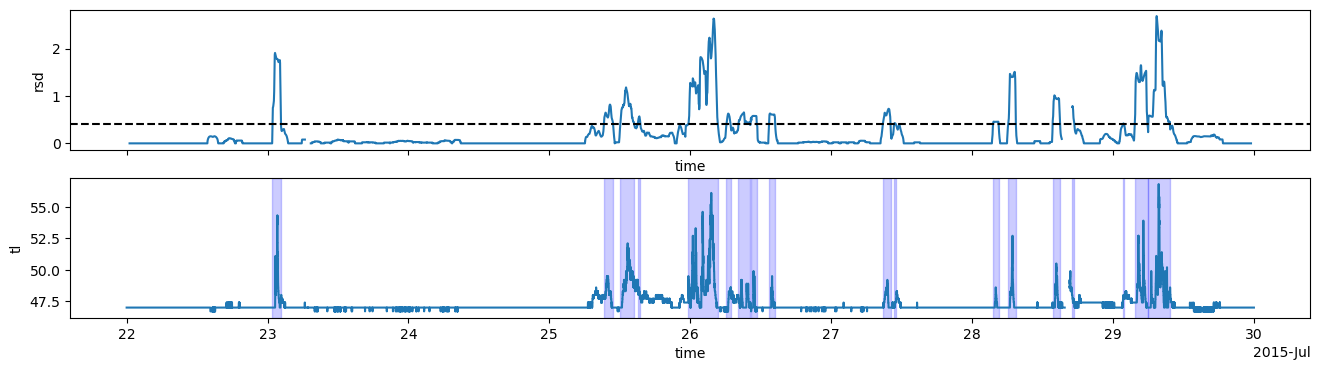

In [70]:
# 3.2
fig, axs = plt.subplots(2, 1, figsize=(16,4), sharex=True)
ds_cml.rsd.plot.line(x='time', ax=axs[0])
axs[0].axhline(threshold, color='k', linestyle='--', label='threshold')
ds_cml.tl.plot.line(x='time', ax=axs[1]);

# Get start and end of dry event
wet_start = np.roll(ds_cml.wet, -1) & ~ds_cml.wet
wet_end = np.roll(ds_cml.wet, 1) & ~ds_cml.wet
# Plot shaded area for each wet event
for wet_start_i, wet_end_i in zip(
    wet_start.values.nonzero()[0],
    wet_end.values.nonzero()[0],
):
    axs[1].axvspan(ds_cml.time.values[wet_start_i], ds_cml.time.values[wet_end_i], color='b', alpha=0.2)
axs[0].set_title('');
axs[1].set_title('');

This is the most basic way of doing a wet-dry classification. The crucial part here is to find the optimal threshold. We used a standard value of 0.8 which is more or less suitable for most CML time series. To get the good performance for CML rainfall estimation this threshold should be adapted to the noisiness of the individual CML time series, e.g. as in [Graf et al. 2020](https://hess.copernicus.org/articles/24/2931/2020/hess-24-2931-2020.html).

# Exercises - would not do  Ex1 and Ex2, but something like plot another CML and threhsold - Ex3 is good for fast people

### Exercise 1 (From Netcdf to wet dry detection)

 1.1 Write a minimal working code example to compute the variable `wet` starting from the NetCDF file.
 
 1.2. Compute `wet` for a different CML with the unique cml_id `67`. 
 - (Hint: You can also use `.sel()` instead of `.isel()` to select by link name. In this particular exercise the link names is just their indice.)
    
 1.3. Use different thresholds for the rolling standard deviation (e.g. 0.1, 1 and 10) to compute `wet`. How do the results differ?

### Exercise 2 (CML data from Sweden)

 1. Repeat exercise 1.1 with CML data from OpenMRG
    * (Hint: Use the provided NetCDF file `./OPENSENSE_training_school_2023/data/cml/openMRG_example.nc`, select the CML number 50 in the dataset, compute `wet` and plot `tl` and `wet` in separate plots.)
    * Note: The data provided here is part of a larger dataset. See https://github.com/OpenSenseAction/OPENSENSE_sandbox/blob/main/notebooks/data/create_small_openMRG_example.ipynb
    * Note: openMRG uses OpenSense naming conventions for the coordinate names, so they can differ slightly from the current pycomlink example

### Exercise 3 (optional)
Plot the number of rain events as a function of the standard deviation `threshold`.

### Exercise 1.1 (From Netcdf to wet dry detection)

 1. Write a minimal working code example to compute the variable `wet` starting from the NetCDF file and plot the tl and the wet variables in separate subplots.

In [20]:
# Write code here:

**Caution:** Running the following cell will load the hints!

In [ ]:
if input("Enter 'Hint' to display the hints: ")=='Hint':
    %load hints_solutions/1_1_hint.py

**Caution:** Running the following cell will load the solution!

In [ ]:
if input("Enter 'Solution' to display solutions: ")=='Solution':
    %load hints_solutions/1_1_solution.py

### Exercise 1.2 (From Netcdf to wet dry detection)

 2. Compute `wet` for a different CML with the unique cml_id `67`. 
- (Hint: You can also use `.sel()` instead of `.isel()` to select by link name. In this particular exercise the link names is just their indice.)

In [ ]:
# Write code here:


**Caution:** The following cell will load the solution!

In [ ]:
if input("Enter 'Solution' to display solutions: ")=='Solution':
    %load hints_solutions/1_2_solution.py

### Exercise 1.3 (From Netcdf to wet dry detection)
 3. Use different thresholds for the rolling standard deviation (e.g. 0.1, 1 and 10) to compute `wet`.

In [ ]:
# Write code here:


**Caution:** The following cell will load the solution!

In [ ]:
if input("Enter 'Solution' to display solutions: ")=='Solution':
    %load hints_solutions/1_3_solution.py

### Exercise 2 (CML data from Gothenburg - OpenMRG)

Repeat exercise 1.1 with CML data from Gothenburg Sweeden, the OpenMRG dataset. Use the provided NetCDF file `./OPENSENSE_training_school_2023/data/cml/openMRG_example.nc`, select CML number 50, compute `wet` and plot `tl` and `wet` in separate plots. 

In [ ]:
# Write code here:


**Caution:** The following cell will load the solution!

In [ ]:
if input("Enter 'Solution' to display solutions: ")=='Solution':
    %load hints_solutions/1_2_1_solution.py

### Exercise 3 (optional)

Plot the number of rain events as a function of the standard deviation `threshold`

In [ ]:
# Write code here:


## What happened so far:

In [123]:
ds_cml = xr.open_dataset('example_data/openmrg_cml_8d.nc').isel(sublink_id = 0, cml_id = 5).load()

ds_cml['tl'] = ds_cml.tsl - ds_cml.rsl 

ds_cml['rsd'] = ds_cml.tl.rolling(time=60*6, center=True).std() 
ds_cml['wet'] = ds_cml.rsd > 0.2


# 3. Estimate a baseline 
**Goal**: Get the atteunuation caused by rain during each dry period.

In [124]:
ds_cml['baseline'] = pycml.processing.baseline.baseline_constant(
    trsl=ds_cml.tl, 
    wet=ds_cml.wet, 
    n_average_last_dry=5*6)  # last 5 minutes

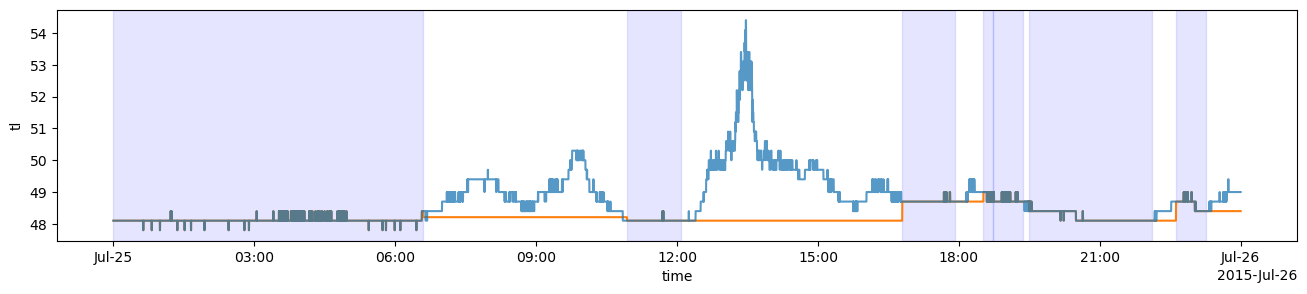

In [125]:

########
## why is shading reversed?????



fig, ax = plt.subplots(1, 1, figsize=(16,3))

ds_cml_zoom = ds_cml.sel(time='2015-07-25')
ds_cml_zoom.baseline.plot.line(x='time', color='C1', ax=ax);
ds_cml_zoom.tl.plot.line(x='time', alpha=0.75, ax=ax)
ax.set_ylabel('tl');
plt.gca().set_prop_cycle(None)

# Get start and end of dry event
wet_start = np.roll(ds_cml_zoom.wet, -1) & ~ds_cml_zoom.wet
wet_end = np.roll(ds_cml_zoom.wet, 1) & ~ds_cml_zoom.wet
# Plot shaded area for each wet event
for wet_start_i, wet_end_i in zip(
    wet_start.values.nonzero()[0],
    wet_end.values.nonzero()[0],
):
    ax.axvspan(ds_cml_zoom.time.values[wet_start_i], ds_cml_zoom.time.values[wet_end_i], color='b', alpha=0.1)
ax.set_title('');

# 4. Compensate for wet antenna attenuation
**Goal**: Rain drops on the antenna cover can create additional attenuation that we need to subtract before estimating the path averaged rainfall rate.

In [126]:
ds_cml['waa'] = pycml.processing.wet_antenna.waa_schleiss_2013(
    rsl=ds_cml.tl, 
    baseline=ds_cml.baseline, 
    wet=ds_cml.wet, 
    waa_max=2.2, 
    delta_t=1, 
    tau=15*6,
)

In [127]:
ds_cml['A'] = ds_cml.tl - ds_cml.baseline - ds_cml.waa # subtract baseline and wet antenna attenuation from total path loss
ds_cml['A'] = ds_cml.A.where(ds_cml.A > 0, 0) # set negative values to zero

# also calc A without WAA compensation for illustration purposes
ds_cml['A_no_waa_correct'] = ds_cml.tl - ds_cml.baseline
ds_cml['A_no_waa_correct'] = ds_cml.A_no_waa_correct.where(ds_cml.A_no_waa_correct > 0, 0)

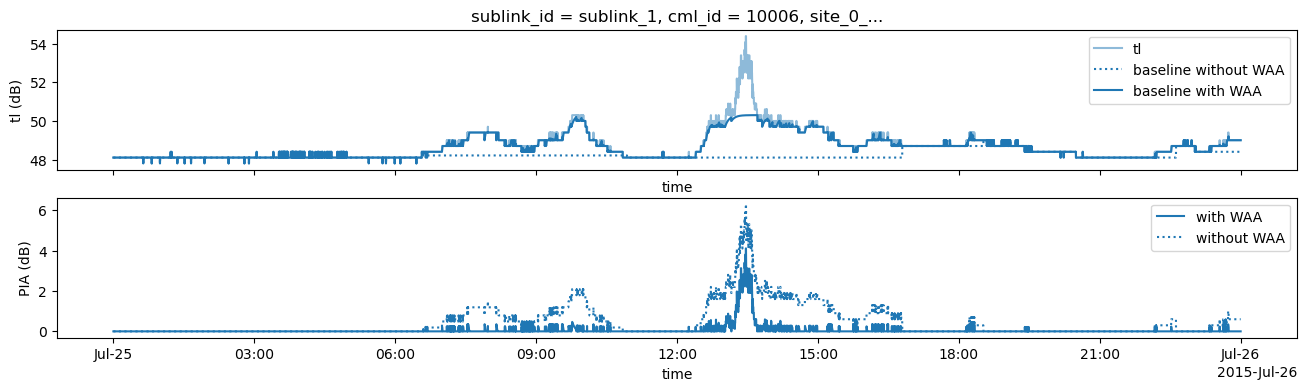

In [128]:
ds_cml_zoom = ds_cml.sel(time='2015-07-25')


fig, axs = plt.subplots(2, 1, figsize=(16,4), sharex=True)
ds_cml_zoom.tl.plot.line(x='time', alpha=0.5, color='tab:blue', label='tl', ax=axs[0])
ds_cml_zoom.baseline.plot.line(
    x='time', 
    linestyle=':', 
    color='tab:blue', 
    label='baseline without WAA', 
    ax=axs[0]
)
(ds_cml_zoom.baseline + ds_cml_zoom.waa).plot.line(
    x='time', 
    color='tab:blue', 
    label='baseline with WAA', 
    ax=axs[0]
)
ds_cml_zoom.A.plot.line(x='time', color='tab:blue', label='with WAA', ax=axs[1])
ds_cml_zoom.A_no_waa_correct.plot.line(x='time', linestyle=':', color='tab:blue', label='without WAA', ax=axs[1])

axs[0].set_ylabel('tl (dB)')
axs[1].set_ylabel('PIA (dB)')
axs[1].set_title('')
axs[1].legend()
axs[0].legend();

## 5 Calculate rain rate

<img src="https://wires.onlinelibrary.wiley.com/cms/asset/0bbeb412-fe72-4d18-b201-f6dadefe60bc/wat21337-fig-0003-m.jpg" alt="drawing" width="1000"/>

**Goal**: Use the k-R relation to transform attenuation into rain rate. The relation depends on the CML frequency.

### 5.1 Compute path averaged rain rate

In [134]:
ds_cml['R_rollstd'] = pycml.processing.k_R_relation.calc_R_from_A(
    A=ds_cml.A, 
    L_km=float(ds_cml.length)/1000, 
    f_GHz=ds_cml.frequency/1000,
    pol=ds_cml.polarization
)

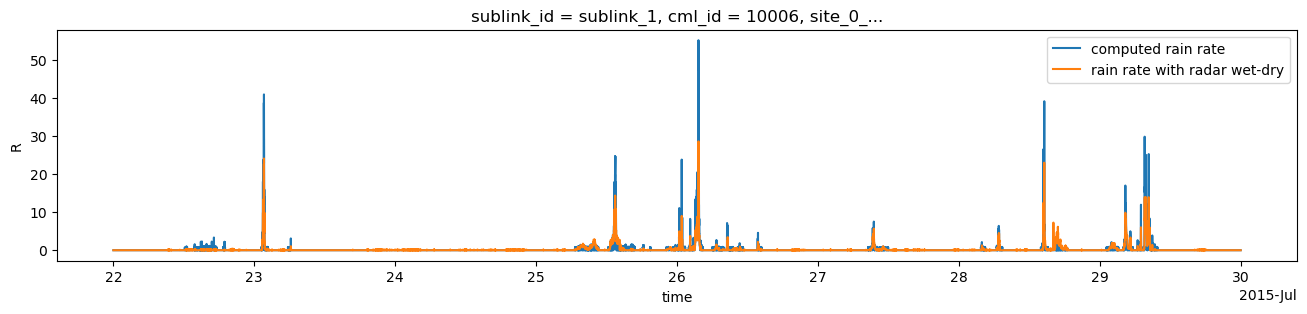

In [135]:
fig, ax = plt.subplots(figsize=(16,3))
ds_cml.R_rollstd.plot.line(x='time',label='computed rain rate')
ds_cml.R.plot.line(x='time',label='rain rate with radar wet-dry')
plt.legend()


# Exercises: -- probaly no  time here


### Exercise 4:
Compute the rainrate for link 50 in the OpenMRG dataset for all timesteps. 

In [ ]:
# Code: 

### Exercise 5:
Compute the rainrate for link 50, but set frequency equal to 20 GHz instead. How much to the estimates differ and what implications does this have for CML rainfall estimation? 

In [ ]:
# Code: 

### Exercise 6:
How does the RSD threshold for wet dry detection affect the estimated rainfall ammounts? 

In [ ]:
# Code: 

# 6. The nearby rain approach - made for data from CML performance reports

In [ ]:
Instanteanous to min-max data and calculation of attenuation
Transfering instantaneous example data to 15 minute (interval) min-max data defining the minmal number of hours (min_hours) needed in a given time period (time period) to calssify wet and dry periods in the subsequent step. If no tsl data is available, a constant tsl has to be assumed and incoporated in CMLs.

Also, this step calculates deltaP (attenuation) and deltaPL (specific attenuation)

In [137]:
import pycomlink.processing.wet_dry.nearby_wetdry as nearby_wetdry
import pycomlink.processing.nearby_rain_retrival as nearby_rain

In [139]:
ds_cmls['length'][:]=ds_cmls.length/1000
rstl = ds_cmls.rsl - ds_cmls.tsl
pmin = rstl.resample(time="15min").min()
pmax = rstl.resample(time="15min").max()

In [141]:
ds_cmls

<xarray.Dataset> Size: 1GB
Dimensions:       (sublink_id: 2, cml_id: 364, time: 69120)
Coordinates:
  * sublink_id    (sublink_id) <U9 72B 'sublink_1' 'sublink_2'
  * cml_id        (cml_id) int64 3kB 10001 10002 10003 ... 10362 10363 10364
  * time          (time) datetime64[ns] 553kB 2015-07-22 ... 2015-07-29T23:59:50
    site_0_lat    (cml_id) float64 3kB ...
    site_0_lon    (cml_id) float64 3kB ...
    site_1_lat    (cml_id) float64 3kB ...
    site_1_lon    (cml_id) float64 3kB ...
    frequency     (sublink_id, cml_id) float64 6kB ...
    polarization  (sublink_id, cml_id) <U1 3kB ...
    length        (cml_id) float64 3kB 0.6914 0.6146 0.3237 ... 4.806 1.412
Data variables:
    tsl           (time, sublink_id, cml_id) float64 403MB ...
    rsl           (time, sublink_id, cml_id) float64 403MB -46.0 -41.0 ... -49.2
    R             (sublink_id, cml_id, time) float64 403MB ...
Attributes: (12/14)
    title:                 OpenMRG-CML
    version:               1.1
    source:                Swedish Meteorological and Hydrological Institute ...
    contact:               hydro.fou@smhi.se, jafet.andersson@smhi.se
    license:               https://creativecommons.org/licenses/by-sa/4.0
    doi:                   https://doi.org/10.5281/zenodo.6673750
    ...                    ...
    institution:           NA
    date:                  NA
    history:               NA
    naming convention:     NA
    license restrictions:  NA
    reference:             NA

In [146]:
ds_dist = nearby_wetdry.calc_distance_between_cml_endpoints(
    cml_ids=ds_cmls.cml_id.values,
    site_a_latitude=ds_cmls.site_0_lat,
    site_a_longitude=ds_cmls.site_0_lon,
    site_b_latitude=ds_cmls.site_1_lat,
    site_b_longitude=ds_cmls.site_1_lon,
)

364it [00:01, 262.07it/s]


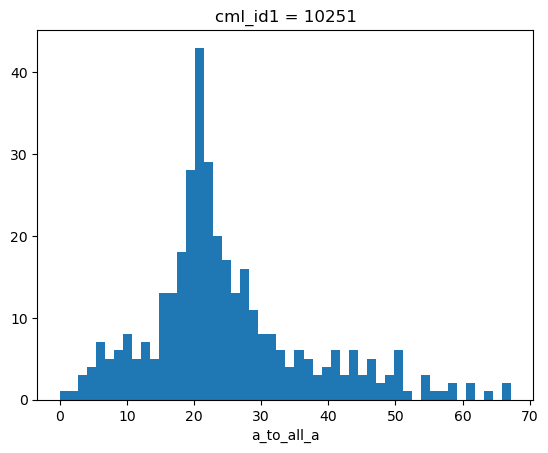

In [147]:
ds_dist.isel(cml_id1=250).a_to_all_a.plot.hist(bins=50);


In [148]:
r=15 # radius in km
ds_dist["within_r"] = (
        (ds_dist.a_to_all_a < r)
        & (ds_dist.a_to_all_b < r)
        & (ds_dist.b_to_all_a < r)
        & (ds_dist.b_to_all_b < r)
)

In [151]:
wet, F = nearby_wetdry.nearby_wetdry(
    pmin=pmin,
    ds_dist=ds_dist,
    radius=15,
    thresh_median_P=-1.4,
    thresh_median_PL=-0.7,
    min_links=3,
    interval=15,
    timeperiod=24,
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 364/364 [00:15<00:00, 22.93it/s]


In [153]:
ds_cml_zoom

<xarray.Dataset> Size: 700kB
Dimensions:           (time: 8640)
Coordinates:
    sublink_id        <U9 36B 'sublink_1'
    cml_id            int64 8B 10006
  * time              (time) datetime64[ns] 69kB 2015-07-25 ... 2015-07-25T23...
    site_0_lat        float64 8B 57.7
    site_0_lon        float64 8B 11.96
    site_1_lat        float64 8B 57.7
    site_1_lon        float64 8B 11.96
    frequency         float64 8B 3.724e+04
    polarization      <U1 4B 'v'
    length            float64 8B 704.8
Data variables:
    tsl               (time) float64 69kB 3.0 3.0 3.0 3.0 ... 3.0 3.0 3.0 3.0
    rsl               (time) float64 69kB -45.1 -45.1 -45.1 ... -46.0 -46.0
    R                 (time) float64 69kB 0.0 0.0 0.0 0.0 ... 0.19 0.19 0.19
    tl                (time) float64 69kB 48.1 48.1 48.1 48.1 ... 49.0 49.0 49.0
    rsd               (time) float64 69kB 9.835e-09 9.835e-09 ... 0.5018 0.5019
    wet               (time) bool 9kB False False False False ... True True True
    baseline          (time) float64 69kB 48.1 48.1 48.1 48.1 ... 48.4 48.4 48.4
    waa               (time) float64 69kB 0.0 0.0 0.0 0.0 ... 0.6 0.6 0.6 0.6
    A                 (time) float64 69kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    A_no_waa_correct  (time) float64 69kB 0.0 0.0 0.0 0.0 ... 0.6 0.6 0.6 0.6
Attributes: (12/14)
    title:                 OpenMRG-CML
    version:               1.1
    source:                Swedish Meteorological and Hydrological Institute ...
    contact:               hydro.fou@smhi.se, jafet.andersson@smhi.se
    license:               https://creativecommons.org/licenses/by-sa/4.0
    doi:                   https://doi.org/10.5281/zenodo.6673750
    ...                    ...
    institution:           NA
    date:                  NA
    history:               NA
    naming convention:     NA
    license restrictions:  NA
    reference:             NA

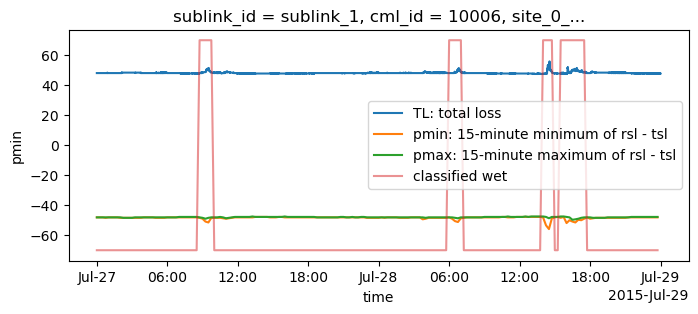

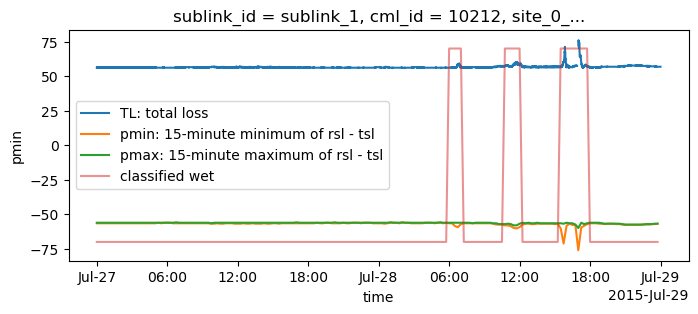

In [168]:
t_start, t_end = "2015-07-27", "2015-07-28 "
for cmlid in [5, 211]:
    (ds_cmls.isel(cml_id=cmlid).tsl - ds_cmls.isel(cml_id=cmlid).rsl).isel(sublink_id=0).sel(
        time=slice(t_start, t_end)
    ).plot(figsize=(8, 3), label="TL: total loss")
    pmin.isel(cml_id=cmlid,sublink_id=0).sel(time=slice(t_start, t_end)).plot(
        label="pmin: 15-minute minimum of rsl - tsl"
    )
    pmax.isel(cml_id=cmlid,sublink_id=0).sel(time=slice(t_start, t_end)).plot(
        label="pmax: 15-minute maximum of rsl - tsl"
    )
    (
        (wet.isel(sublink_id=0,cml_id=cmlid).sel(time=slice(t_start, t_end)) * 140)
        - 70
    ).plot(label="classified wet", alpha=0.5)

    plt.legend()

**Baseline estimation (pref)**  
The baseline is set to the rolling median of the average of pmin and pmax during the last n_average_dry time steps. Default is 24 hours (n_average_dry=96 because 15 minute temporal resolution) and a baseline will be calculated when at least one time step is available (min_periods=1) If pmax is not available e.g. because the min-max data is derived from instanteanous sampled CML data and has the same temporal resolution as the instanteanous CML data, substitute pmax with pmin so pmin and pmax are identical.

In [169]:
pref = nearby_rain.nearby_determine_reference_level(pmin, pmax, wet, n_average_dry=96, min_periods=1)


**Correction if min-max data**
Correcting pmin and pmax so that no rainfall estimation is carried out during dry time steps. All time steps of pmin which are not classified wet and pmin is smaller than pref are set to pref. Similarly, all time steps of pmax where either the corrected pmin (p_c_min) is not smaller than pref or pmax is not smaller than pref are set to pref. This ensures that only wet time steps are used for rainfall estimation an and that pmax is not above pref which would lead to an overestimation of rainfall.

In [170]:
p_c_min, p_c_max = nearby_rain.nearby_correct_received_signals(pmin, pmax, wet, pref)


**Calculate rain rates from attenuation data**
Also, correcting for wet antenna attenuation and setting the alpha value which defines how close to the minimum attenuation of each intervall the rain rate should be set.

In [173]:
R = nearby_rain.nearby_rainfall_retrival(
    pref,
    p_c_min,
    p_c_max,
    F,
    length=pmin.length,
    f_GHz=pmin.frequency / 1e3,
    pol=pmin.polarization,
    waa_max=2.3,
    alpha=0.33,
    F_value_threshold =-32.5,
)

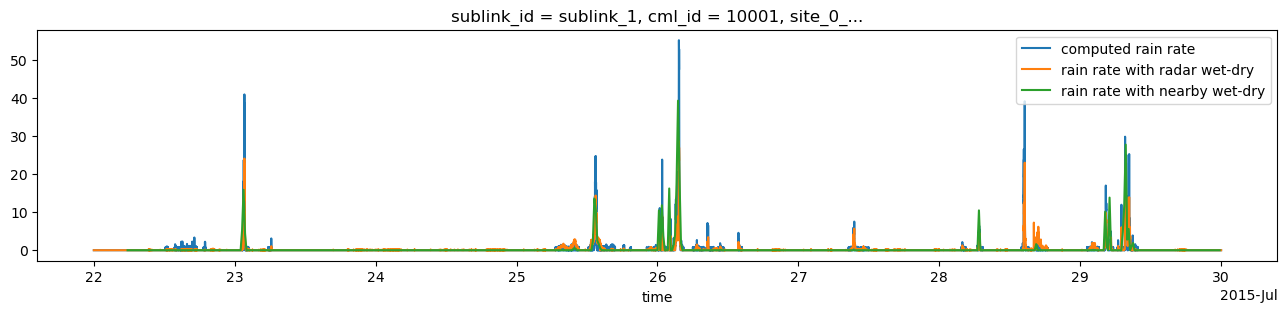

In [179]:
fig, ax = plt.subplots(figsize=(16,3))
ds_cml.R_rollstd.plot.line(x='time',label='computed rain rate')
ds_cml.R.plot.line(x='time',label='rain rate with radar wet-dry')
R.isel(sublink_id=0,cml_id=0).plot(label='rain rate with nearby wet-dry')
plt.legend()

.. more  wet dry?

.. more wet antenna?

# 7. Evaluation of CML rainfall estimates against rain gauges and rainm1

In [ ]:
evaluate the two methods...